In [1]:
from google.colab import drive
drive.mount('/content/colabdrive')

Drive already mounted at /content/colabdrive; to attempt to forcibly remount, call drive.mount("/content/colabdrive", force_remount=True).


In [0]:
import os
os.chdir("/content/colabdrive/My Drive/STAT5242/Project/Output/MNIST/[Modified]image")

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [3]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


TensorFlow 2.x selected.


In [0]:
import tensorflow as tf

In [5]:
tf.__version__

'2.0.0'

In [6]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow.keras import layers
import time
from tqdm.autonotebook import tqdm

from IPython import display

/usr/local/lib/python3.6/dist-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [0]:
TRAIN_BUF = 60000
TEST_BUF = 10000
BATCH_SIZE = 256
noise_dim = 100

In [0]:
# load dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

# split dataset
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype("float32")
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype("float32")

# Normalize the images to [-1, 1]
train_images = (train_images - 127.5) / 127.5
test_images = (test_images - 127.5) / 127.5 

# batch datasets
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
    .shuffle(TRAIN_BUF)
    .batch(BATCH_SIZE)
)
test_dataset = (
    tf.data.Dataset.from_tensor_slices(test_images)
    .shuffle(TEST_BUF)
    .batch(BATCH_SIZE)
)

# Implement  our  own  GAN  with  CNN  layers  on  MNIST  data.

## Define the network as tf.keras.model object

In [0]:
class GAN(tf.keras.Model):
    """ a GAN class 
    Extends:
        tf.keras.Model
    """

    def __init__(self, **kwargs):
        super(GAN, self).__init__()
        self.__dict__.update(kwargs)

    def generate(self, z):
        return self.gen(z)

    def discriminate(self, x):
        return self.disc(x)

    def compute_loss(self, x):
        """ passes through the network and computes loss
        """
        # generating noise from a uniform distribution
        noise = tf.random.normal([self.BATCH_SIZE, noise_dim])
      
        # run noise through generator
        x_gen = self.generate(noise)

        # discriminate original_image and new_generated_image
        logits_x = self.discriminate(x)
        logits_x_gen = self.discriminate(x_gen)

        ### losses
        cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        
        # discriminator loss
        disc_real_loss = cross_entropy(tf.ones_like(logits_x), logits_x)
        disc_fake_loss = cross_entropy(tf.zeros_like(logits_x_gen), logits_x_gen)
        disc_loss = disc_real_loss + disc_fake_loss

        # generator loss
        gen_loss = cross_entropy(tf.ones_like(logits_x_gen), logits_x_gen)

        return disc_loss, gen_loss

    def compute_gradients(self, x):
        """ passes through the network and computes loss
        """
        ### pass through network
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            disc_loss, gen_loss = self.compute_loss(x)

        # compute gradients
        gen_gradients = gen_tape.gradient(gen_loss, self.gen.trainable_variables)
        disc_gradients = disc_tape.gradient(disc_loss, self.disc.trainable_variables)

        return gen_gradients, disc_gradients

    def apply_gradients(self, gen_gradients, disc_gradients):

        self.gen_optimizer.apply_gradients(
            zip(gen_gradients, self.gen.trainable_variables)
        )
        self.disc_optimizer.apply_gradients(
            zip(disc_gradients, self.disc.trainable_variables)
        )
    @tf.function
    def train(self, train_x):
        gen_gradients, disc_gradients = self.compute_gradients(train_x)
        self.apply_gradients(gen_gradients, disc_gradients)

## Define CNN architecture

In [11]:
from keras.layers import UpSampling2D

Using TensorFlow backend.


In [0]:
def generator():
    model = tf.keras.Sequential()

    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size
    model.add(layers.Dropout(0.4))

    model.add(layers.UpSampling2D())
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 128)
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU())

    model.add(layers.UpSampling2D())
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 28, 28, 64)
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 28, 28, 32)
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='sigmoid'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [20]:
new_generator = generator()
new_generator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 12544)             1254400   
_________________________________________________________________
batch_normalization_2 (Batch (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 12544)             0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 256)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)      

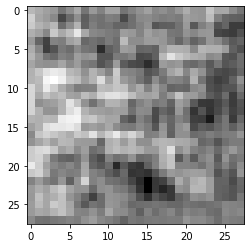

In [21]:
noise = tf.random.normal([1, 100])
new_generated_image = new_generator(noise, training=False)

plt.imshow(new_generated_image[0, :, :, 0], cmap='gray')

In [0]:
def discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.4))

    
    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.4))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    model.add(layers.Activation('sigmoid'))

    return model

In [23]:
new_discriminator = discriminator()
new_discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)        

In [24]:
new_decision = new_discriminator(new_generated_image)
print (new_decision)

tf.Tensor([[0.4983757]], shape=(1, 1), dtype=float32)


## Build model

In [0]:
# optimizers
gen_optimizer = tf.keras.optimizers.Adam(0.001, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.RMSprop(0.005)# train the model
# or
# generator_optimizer = tf.keras.optimizers.Adam(1e-4)
# discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

num_examples_to_generate = 16
# model
model = GAN(
    gen = new_generator,
    disc = new_discriminator,
    gen_optimizer = gen_optimizer,
    disc_optimizer = disc_optimizer,
    BATCH_SIZE = BATCH_SIZE
)

## Train the model

In [0]:
n_epochs = 100
N_TRAIN_BATCHES =int(TRAIN_BUF/BATCH_SIZE)
N_TEST_BATCHES = int(TEST_BUF/BATCH_SIZE)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [0]:
# exampled data for plotting results
def generate_and_save_images(epoch, test_input):
    samples = model.generate(test_input)
    fig = plt.figure(figsize=(4,4))

    for i in range(samples.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(samples[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [0]:
# a pandas dataframe to save the loss information to
losses = pd.DataFrame(columns = ['disc_loss', 'gen_loss'])

In [0]:
def train(n_epochs):
    for epoch in range(n_epochs):
        # train
        for batch, train_x in tqdm(
            zip(range(N_TRAIN_BATCHES), train_dataset), total=N_TRAIN_BATCHES
        ):
            model.train(train_x)
 
        # test on holdout
        loss = []
        for batch, test_x in tqdm(
            zip(range(N_TEST_BATCHES), test_dataset), total=N_TEST_BATCHES
        ):
            loss.append(model.compute_loss(train_x))
        losses.loc[len(losses)] = np.mean(loss, axis=0)
        # plot results
        display.clear_output(wait=True)
        print ('Image for epoch {}'.format(epoch + 1))
        generate_and_save_images(epoch + 1,
                                seed)


        print(
            "Epoch: {} | disc_loss: {} | gen_loss: {}".format(
                epoch, losses.disc_loss.values[-1], losses.gen_loss.values[-1]
            )
        )


    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(n_epochs,
                              seed)

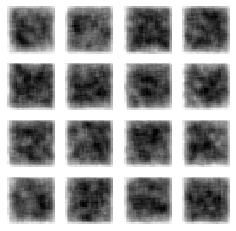

In [86]:
train(n_epochs)

In [0]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [0]:
display_image(EPOCHS)

In [0]:
anim_file = 'dcgan_new_architecture.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)